In [1]:
import time
import numpy as np
import yaml
import autograd.numpy as np1
from scipy.optimize import Bounds
import torch
from torch import Tensor, optim
import torch.optim.lr_scheduler as lr_scheduler
from utils import circle_points, plot_trajectories

In [2]:
from tqdm import tqdm
from hypernet_trans import Hypernet_trans
import math

In [3]:
import autograd.numpy as np
from scipy.optimize import minimize            
from scipy.optimize import BFGS
        
class Projection:
    def __init__(self, cons, bounds, dim, proj_type='euclid'):
        """
        cons: Ràng buộc (constraints)
        bounds: Giới hạn biên (bounds)
        n: Số chiều
        proj_type: Loại phép chiếu ('euclid' cho miền C hoặc 'qplus' cho miền Q+)
        """
        self.cons = cons
        self.bounds = bounds
        self.dim = dim
        self.proj_type = proj_type
        
        # Cấu hình hàm mục tiêu dựa trên loại phép chiếu
        if self.proj_type == 'qplus':
            self.objective_func = self._obj_positive_diff
        elif self.proj_type == 'euclid':
            self.objective_func = self._obj_l2_norm
        else:
            print(f"Phép chiếu {self.objective_func} không cài đặt, chọn 'qplus' hoặc 'euclid'")

    def _obj_l2_norm(self, x, y):
        """Hàm mục tiêu khoảng cách Euclid chuẩn (Dùng cho C)"""
        return np.sqrt(np.sum((x - y)**2))
    
    def _obj_positive_diff(self, x, y):
        """Hàm mục tiêu (Dùng cho Qplus)"""
        v = np.maximum(y - x, 0) 
        return np.sum(v**2)

    def project(self, target_point):
        """
        init_point: Điểm khởi tạo
        target_point: Điểm cần chiếu 
        """
        
        init_point = np.random.rand(1, self.dim).tolist()[0]
        
        res = minimize(
            self.objective_func,
            init_point,
            args=(target_point, ),
#             jac="2-point",
#             hess=BFGS(),
            constraints=self.cons,
#             method="trust-constr",
            bounds=self.bounds,
            options={'disp': False}
        )
        
        optim_point = res.x
        
        if self.proj_type == 'qplus':
            return target_point - np.maximum(target_point - optim_point, 0)
        else:
            return optim_point

In [4]:
class Problem():
    def __init__(self, f, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)  

# Define

In [8]:
def f(x):
    return np.array([
        4*x[0]**2 + 4*x[1]**2,
        (x[0] - 5)**2 + (x[1] - 5)**2
    ])

def f1(x):
    return 4*x[0]**2 + 4*x[1]**2
def f2(x):
    return (x[0] - 5)**2 + (x[1] - 5)**2
#--------------- C --------------------#
def c1(x):
    return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x):
    return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7


#--------------- Q --------------------#
def q1(y):
    return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2

def q_plus(y):
    center = 50.0
    radius_sq = 50**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 2
bounds_x = Bounds([-15,-15],[30, 30])

cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

In [16]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f1, f2], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)
z_star = np.array([75.23366646094793, 25.502227623508944])

In [17]:
config_path='../4_Pareto_front/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
test_rays = np.array(cfg['data']['test_ray'])

In [31]:
def evaluate_objectives_single(functions, x_tensor):
    """
    Tính f1, f2 cho 1 mẫu x duy nhất.
    Args:
        x_tensor: Shape (Dim_x,) -> VD: (2,)
    Returns:
        Tensor Shape (Num_Obj,) -> VD: (2,)
    """
    vals = []
    for func in functions:
        val = func(x_tensor)
        if not torch.is_tensor(val):
            val = torch.tensor(val, dtype=torch.float32)
        vals.append(val)
    
    return torch.stack(vals).reshape(-1)

def train_hypernet(hypernet, prob, z_star, 
                   num_epochs=1000, 
                   lr=1e-3, 
                   num_partitions=100, 
                   lr_step_size=300, 
                   lr_gamma=0.5,
                   init_penalty_weight=10.0,
                   penalty_decay=0.999):
    
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    
    # Đảm bảo z_star chuẩn shape (1, 2)
    z_star_tensor = torch.tensor(z_star, dtype=torch.float32).view(1, -1)
    
    current_penalty = init_penalty_weight
    angle_step = (math.pi / 2) / num_partitions
    
    print(f"=== TRAIN HYPERNET (Penalty Method for both C & Q) ===")
    
    for epoch in range(num_epochs):
        hypernet.train()
        optimizer.zero_grad()
        
        # 1. Stratified Sampling
        starts = torch.arange(num_partitions) * angle_step
        noise = torch.rand(num_partitions) * angle_step
        thetas = starts + noise 
        
        r_batch_np = np.stack([np.cos(thetas.numpy()), np.sin(thetas.numpy())], axis=1)
        r_tensor_batch = torch.tensor(r_batch_np, dtype=torch.float32) # Shape (100, 2)
        
        # 2. Sequential Forward
        x_pred_list = []
        for i in range(num_partitions):
            r_single = r_tensor_batch[i].unsqueeze(0)
            x_single = hypernet(r_single)
            x_pred_list.append(x_single)
            
        x_vec_batch = torch.cat(x_pred_list, dim=0) # Shape (100, 2)
        
        # 3. Tính toán Loss 
        x_np_batch = x_vec_batch.detach().cpu().numpy()
        
        loss_C_list = [] # Danh sách loss cho C
        loss_Q_list = []
        y_pred_list = []
        
        for i in range(num_partitions):
            # Lấy 1 mẫu: shape (2,)
            x_i_tensor = x_vec_batch[i]
            x_i_np = x_np_batch[i]
            
            # --- a. Tính Loss C (Khoảng cách từ x đến proj_C(x)) ---
            x_proj_i_np = prob.proj_C(x_i_np)
            x_proj_i_tensor = torch.tensor(x_proj_i_np, dtype=torch.float32)
            
            # Tính khoảng cách bình phương làm loss phạt cho C
            loss_C_list.append(torch.sum((x_i_tensor - x_proj_i_tensor)**2))
            
            # --- b. Tính F(x) dùng output GỐC của mạng (không qua STE) ---
            # Output shape bảo đảm là (2,)
            y_pred_i = evaluate_objectives_single(prob.f, x_i_tensor)
            y_pred_list.append(y_pred_i)
            
            # --- c. Tính Loss Q (Khoảng cách từ y đến proj_Q+(y)) ---
            y_i_np = y_pred_i.detach().cpu().numpy()
            y_proj_i_np = prob.proj_Qplus(y_i_np)
            y_proj_i_tensor = torch.tensor(y_proj_i_np, dtype=torch.float32)
            
            loss_Q_list.append(torch.sum((y_pred_i - y_proj_i_tensor)**2))
        
        # Stack lại: List 100 cái (2,) -> Tensor (100, 2)
        y_pred_batch = torch.stack(y_pred_list)
        
        # Tính trung bình loss phạt
        loss_C = torch.mean(torch.stack(loss_C_list))
        loss_Q = torch.mean(torch.stack(loss_Q_list))
        
        # 4. Chebyshev Loss
        # diff: (100, 2) - (1, 2) -> (100, 2)
        diff = y_pred_batch - z_star_tensor 
        
        # weighted_diff: (100, 2) * (100, 2) -> (100, 2)
        weighted_diff = r_tensor_batch * diff
        
        max_vals, _ = torch.max(weighted_diff, dim=1) # (100,)
        loss_obj = torch.mean(max_vals)
        
        # 5. Backward (Tổng hợp cả Loss C và Loss Q vào penalty)
        total_loss = loss_obj + current_penalty * (loss_C + loss_Q)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        current_penalty = min(100, current_penalty * penalty_decay)
        
        if epoch % 10 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}: Total={total_loss.item():.4f} (Obj={loss_obj.item():.4f}, C={loss_C.item():.4f}, Q={loss_Q.item():.4f}) || Pen={current_penalty:.2f}")
            
    return hypernet

In [32]:
hypernet_c = Hypernet_trans(ray_hidden_dim=32, out_dim=prob.dim_x, n_tasks=2)

In [ ]:
trained_c = train_hypernet(hypernet_c, prob, z_star, num_epochs=300, init_penalty_weight=10.0, penalty_decay=1.01)

=== TRAIN HYPERNET (Penalty Method for both C & Q) ===
Epoch 0: Total=191.8962 (Obj=11.5872, C=18.0309, Q=0.0000) || Pen=10.10
Epoch 10: Total=143.3302 (Obj=9.8713, C=12.0819, Q=0.0000) || Pen=11.16
Epoch 20: Total=73.1564 (Obj=8.3206, C=5.3136, Q=0.0000) || Pen=12.32
Epoch 30: Total=11.3874 (Obj=10.6055, C=0.0580, Q=0.0000) || Pen=13.61
Epoch 40: Total=9.9875 (Obj=7.1320, C=0.1918, Q=0.0000) || Pen=15.04
Epoch 50: Total=10.2980 (Obj=5.2626, C=0.3062, Q=0.0000) || Pen=16.61
Epoch 60: Total=5.8149 (Obj=4.9523, C=0.0475, Q=0.0000) || Pen=18.35
Epoch 70: Total=4.8252 (Obj=3.5474, C=0.0637, Q=0.0000) || Pen=20.27
Epoch 80: Total=4.2371 (Obj=2.4908, C=0.0788, Q=0.0000) || Pen=22.39
Epoch 90: Total=3.9008 (Obj=2.0942, C=0.0738, Q=0.0000) || Pen=24.73
Epoch 100: Total=3.5882 (Obj=2.5065, C=0.0400, Q=0.0000) || Pen=27.32


# Test

In [24]:
pf_true = np.load("../4_Pareto_front/test/ex4/pf_true.npy")
target_space = np.load("../4_Pareto_front/test/ex4/target_space.npy")

## Constraint

In [25]:
hypernet_c.eval()

pf_pred = [] 
tmp_err = [] 

t1 = time.time()


print(f"Evaluating on {len(test_rays)} rays...")

for r in test_rays:   
    # --- Dự đoán với Hypernetwork ---
    ray_t = torch.from_numpy(r).float().unsqueeze(0)
    
    with torch.no_grad(): 
        output_x = hypernet_c(ray_t).squeeze()
        vals = [func(output_x).item() for func in prob.f]
        obj_pred = np.array(vals)
    
    pf_pred.append(obj_pred)
    
#     err = np.sum(np.abs(obj_pred - y_test))
#     tmp_err.append(err)
    

t2 = time.time()

pf_pred = np.array(pf_pred)

print("-" * 30)
# print(f"Mean L1 Error: {np.mean(tmp_err):.6f}")
print(f"Inference Time: {t2-t1:.4f}s")

Evaluating on 30 rays...
------------------------------
Inference Time: 0.0130s


<Figure size 1600x800 with 0 Axes>

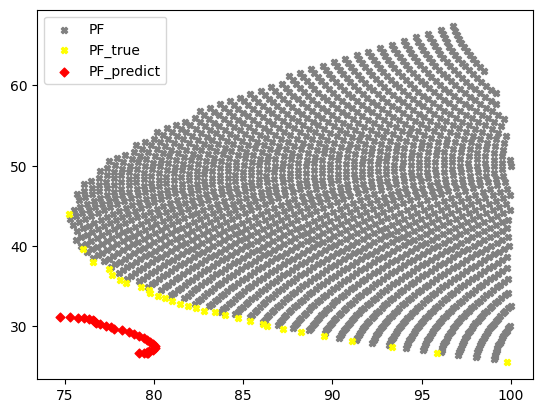

In [26]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))